In [1]:
setwd('..')

In [2]:
getwd()

[1] "D:/okiriza_w/personal/paper 2023"

In [4]:
library(dplyr)

In [5]:
conf_name = '003'

## Read data

In [6]:
conf = jsonlite::fromJSON(sprintf('configs/%s.json', conf_name))
conf

$data_paths
[1] "data/news/kontan/kontan_environment_similarity_company_mentioned.parquet"

$n_pre
[1] 66

$n_post
[1] 5

$normalize
[1] "1_mean"

$causalimpact
$causalimpact$model
$causalimpact$model$standardize.data
[1] FALSE

$causalimpact$model$nseasons
[1] 1

$causalimpact$model$season.duration
[1] 1

In [7]:
events_orig = bind_rows(lapply(conf$data_paths, function(x) if (endsWith(x, '.parquet')) arrow::read_parquet(x) else read.csv(x)))
dim(events_orig)

The tzdb package is not installed. Timezones will not be available to Arrow compute functions.



[1] 11923    11

In [8]:
fpaths_stock_vol = list.files('data/stock_price/yfinance/Volume/', full.names=TRUE)
fpaths_stock_vol

stock_vol_orig = bind_rows(lapply(fpaths_stock_vol, read.csv, sep='|'))
dim(stock_vol_orig)
head(stock_vol_orig)

[1] "data/stock_price/yfinance/Volume/2010.csv"
 [2] "data/stock_price/yfinance/Volume/2011.csv"
 [3] "data/stock_price/yfinance/Volume/2012.csv"
 [4] "data/stock_price/yfinance/Volume/2013.csv"
 [5] "data/stock_price/yfinance/Volume/2014.csv"
 [6] "data/stock_price/yfinance/Volume/2015.csv"
 [7] "data/stock_price/yfinance/Volume/2016.csv"
 [8] "data/stock_price/yfinance/Volume/2017.csv"
 [9] "data/stock_price/yfinance/Volume/2018.csv"
[10] "data/stock_price/yfinance/Volume/2019.csv"
[11] "data/stock_price/yfinance/Volume/2020.csv"
[12] "data/stock_price/yfinance/Volume/2021.csv"
[13] "data/stock_price/yfinance/Volume/2022.csv"
[14] "data/stock_price/yfinance/Volume/2023.csv"

[1] 3582  913

,Date,AALI.JK,ABBA.JK,ABDA.JK,ABMM.JK,ACES.JK,ACST.JK,ADCP.JK,ADES.JK,ADHI.JK,...,WSKT.JK,WTON.JK,YELO.JK,YPAS.JK,YULE.JK,ZATA.JK,ZBRA.JK,ZINC.JK,ZONE.JK,ZYRX.JK
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2010-01-04,1006977,58500,55384,NA,1380000,NA,NA,162000,760195,...,NA,NA,NA,31000,NA,NA,3,NA,NA,NA
2,2010-01-05,1761555,58500,1,NA,2630000,NA,NA,379000,23960287,...,NA,NA,NA,72000,NA,NA,0,NA,NA,NA
3,2010-01-06,1070471,16500,1384,NA,495000,NA,NA,317000,8224249,...,NA,NA,NA,109500,1017,NA,0,NA,NA,NA
4,2010-01-07,2431649,80000,2,NA,995000,NA,NA,216500,28799017,...,NA,NA,NA,106000,NA,NA,0,NA,NA,NA
5,2010-01-08,949256,16000,1,NA,405000,NA,NA,54500,4495758,...,NA,NA,NA,79500,NA,NA,0,NA,NA,NA
6,2010-01-11,806526,16000,20769,NA,455000,NA,NA,207500,1191561,...,NA,NA,NA,90500,NA,NA,0,NA,NA,NA


---

## Process data

In [9]:
stock_vol = stock_vol_orig %>%
    select(matches('^(Date|\\w{4}\\.JK)$')) %>%
    rename_all(function(col_name) substr(col_name, 1, 4)) %>%
    rename(date=Date) %>%
    mutate_all(~ replace(., is.na(.), 0)) %>%
    mutate(date=as.Date(date)) %>%
    filter(rowSums(select(., -date)) > 0)
zoo_stock_vol = zoo::zoo(stock_vol %>% select(-date), as.Date(stock_vol$date))

dim(stock_vol)
head(stock_vol)

[1] 3379  911

,date,AALI,ABBA,ABDA,ABMM,ACES,ACST,ADCP,ADES,ADHI,...,WSKT,WTON,YELO,YPAS,YULE,ZATA,ZBRA,ZINC,ZONE,ZYRX
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2010-01-04,1006977,58500,55384,0,1380000,0,0,162000,760195,...,0,0,0,31000,0,0,3,0,0,0
2,2010-01-05,1761555,58500,1,0,2630000,0,0,379000,23960287,...,0,0,0,72000,0,0,0,0,0,0
3,2010-01-06,1070471,16500,1384,0,495000,0,0,317000,8224249,...,0,0,0,109500,1017,0,0,0,0,0
4,2010-01-07,2431649,80000,2,0,995000,0,0,216500,28799017,...,0,0,0,106000,0,0,0,0,0,0
5,2010-01-08,949256,16000,1,0,405000,0,0,54500,4495758,...,0,0,0,79500,0,0,0,0,0,0
6,2010-01-11,806526,16000,20769,0,455000,0,0,207500,1191561,...,0,0,0,90500,0,0,0,0,0,0


In [10]:
events = events_orig %>%
    dplyr::filter(company_metioned != '') %>%
    tidyr::separate_rows(company_metioned, sep=',') %>%
    dplyr::mutate(date=as.Date(substr(timestamp, 1, 10)))
dim(events)

[1] 14495    12

In [11]:
firm_dates = events %>%
    #filter(date >= '2010-03-01') %>%
    rename(firm=company_metioned) %>%
    group_by(firm, date) %>%
    summarise(n=n(), max_score=max(similarity), sum_score=sum(similarity))
dim(firm_dates)
head(firm_dates)

`summarise()` has grouped output by 'firm'. You can override using the `.groups` argument.


[1] 12843     5

firm,date,n,max_score,sum_score
<chr>,<date>,<int>,<dbl>,<dbl>
AALI,2016-02-05,1,0.6107671,0.6107671
AALI,2016-02-29,1,0.5373070,0.5373070
AALI,2016-03-14,1,0.6783051,0.6783051
AALI,2016-04-25,1,0.6064426,0.6064426
AALI,2016-08-16,1,0.5889188,0.5889188
AALI,2016-09-07,1,0.5048047,0.5048047


In [12]:
table(firm_dates$n)


    1     2     3     4     5     6 
11437  1210   153    37     5     1 

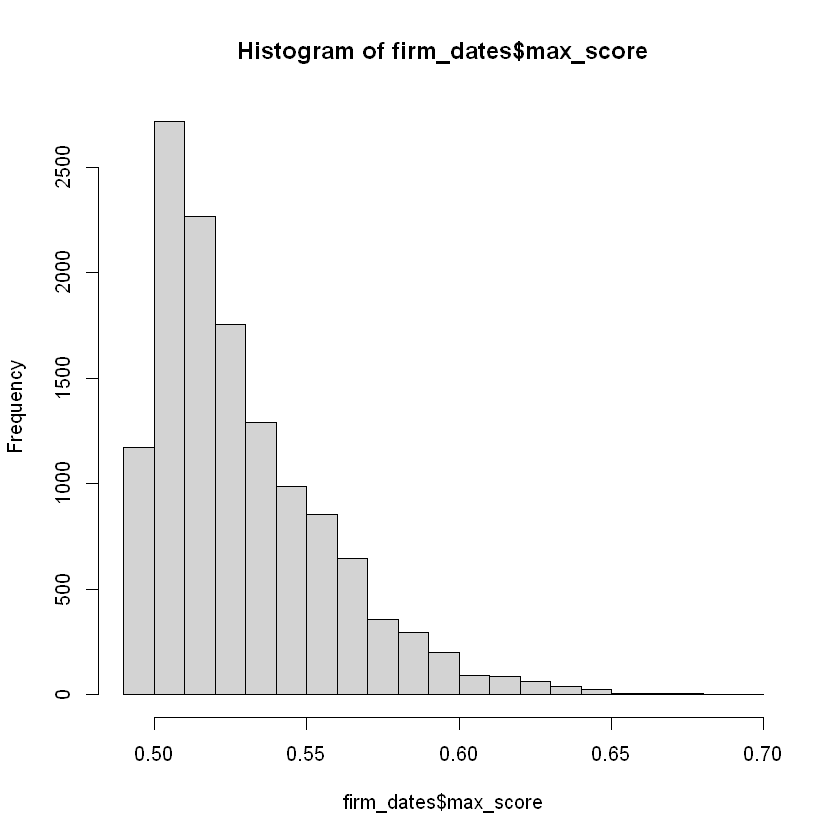

In [13]:
hist(firm_dates$max_score)

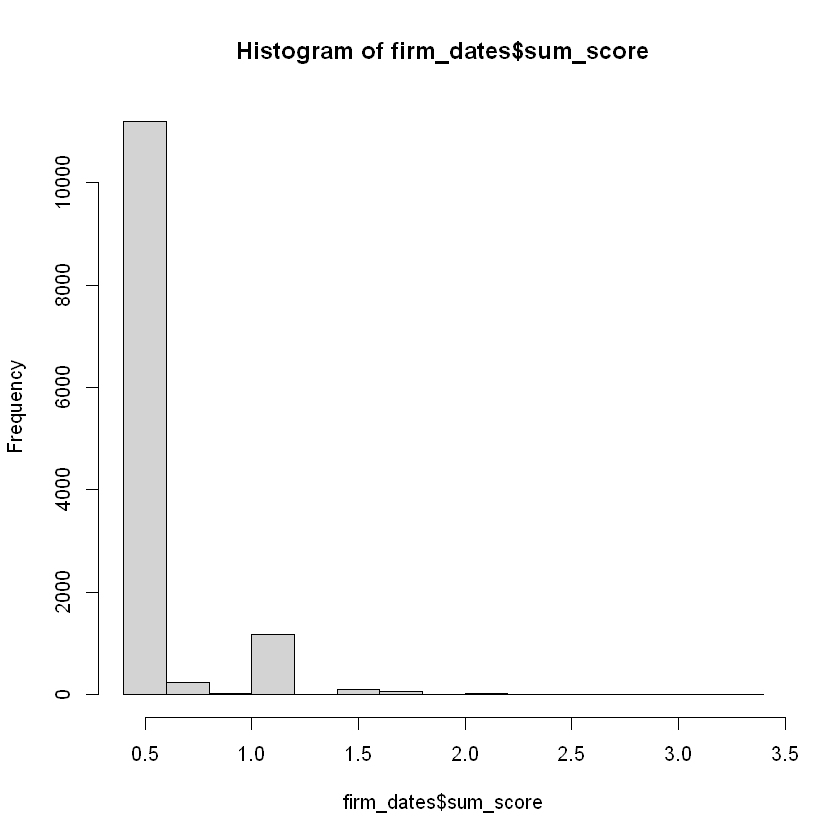

In [14]:
hist(firm_dates$sum_score)

---

## CausalImpact

In [16]:
get_date_index = function(dt, date_col) {
    testit::assert(length(dt) == 1)
    testit::assert(length(date_col) >= 1)
    
    dt = as.Date(dt)
    if (class(date_col) != 'Date') {
        date_col = as.Date(date_col)
    }
    
    max_dt = max(date_col)
    if ((dt > max_dt) | (dt < min(date_col))) {
        return(0)
    }
    
    while (dt <= max_dt) {
        idx = which(date_col == dt)
        if (length(idx) > 0) {
            return(idx)
        }
        
        dt = dt + 1
    }
    return(0)
}


get_series = function(dt, date_col, x, n_pre=66, n_post=5) {
    testit::assert(n_post >= 1)
    testit::assert(n_pre >= 3)
    
    if (length(x) < n_pre + n_post) {
        return()
    }
    
    idx = get_date_index(dt, date_col)
    if (idx == 0) {
        return()
    }
    
    pre = x[max(idx - n_pre, 1):(idx - 1)]
    post = x[idx : min(idx + n_post - 1, length(x))]
    
    if ((length(pre) < n_pre) | (length(post) < n_post)) {
        return()
    }
    
    pre = zoo::zoo(pre, date_col[max(idx - n_pre, 1):(idx - 1)])
    post = zoo::zoo(post, date_col[idx : min(idx + n_post - 1, length(x))])
    
    return(list(pre=pre, post=post, index=idx, date=date_col[idx]))
}

run_causalimpact = function(obs_id, date, date_col, n_pre, n_post, X=NULL, select_data=NULL, normalize=NULL, causalimpact_args=list(), metadata=list()) {
    cat(obs_id); cat(date); cat('  '); flush.console()
    
    testit::assert(!is.null(X) | !is.null(select_data))
    empty_result = list(obs_id=obs_id, event_date=date, metadata=metadata)
    
    if (is.null(select_data)) {
        testit::assert(obs_id %in% names(X))
        testit::assert(nrow(X) > n_pre + n_post)
        testit::assert(nrow(X) == length(date_col))
        
        series = get_series(date, date_col, X[[obs_id]], n_pre=n_pre, n_post=n_post)
        dates = zoo::index(c(series$pre, series$post))
        data = as.data.frame(c(series$pre, series$post))
        names(data) = obs_id
        data = zoo::zoo(data, dates)
    } else {
        data = select_data(obs_id, date, n_pre=n_pre, n_post=n_post)
        dates = zoo::index(data)
    }
    testit::assert(nrow(data) == n_pre + n_post)
    
    if (!is.null(normalize)) {
        if (is.function(normalize)) {
            data[,obs_id] = normalize(data[,obs_id])
        } else {
            testit::assert(normalize %in% c('standardize', '1_mean'))
            
            if (normalize == 'standardize') {
                m = mean(data[1:n_pre, obs_id], na.rm=TRUE)
                s = sd(data[1:n_pre, obs_id], na.rm=TRUE)    # s can be 0 --> CI won't run --> this result will be ignored
                
                if (is.na(s) | (s == 0)) { return(empty_result) }
                data[,obs_id] = (data[,obs_id] - m) / s

            } else if (normalize == '1_mean') {
                m = mean(data[1:n_pre, obs_id], na.rm=TRUE)    # m can be 0 --> CI won't run --> this result will be ignored
                
                if (is.na(m) | (m == 0)) { return(empty_result) }
                data[,obs_id] = data[,obs_id]/m
            }
        }
    }
    
    pre_period = c(dates[1], dates[n_pre])
    post_period = c(dates[n_pre + 1], dates[nrow(data)])
    
    ci_args = causalimpact_args
    # model = CausalImpact::CausalImpact(series, pre.period=c(1,n_pre), post.period=c(n_pre+1, n_pre+n_post))
    model = CausalImpact::CausalImpact(data, pre.period=pre_period, post.period=post_period, model.args=list(
        standardize.data=ci_args$model$standardize.data, nseasons=ci_args$model$nseasons, season.duration=ci_args$model$season.duration))
    
    model$obs_id = obs_id
    model$event_date = date
    model$metadata = metadata
    
    return(model)
}

concat_causalimpact_series = function(ci_results) {
    return(
        bind_rows(
            lapply(ci_results, function(x) {
                if (is.null(x$series)) { return() }
                
                obs_id = x$obs_id
                evt_date = x$event_date
                
                x = as.data.frame(x$series)
                x$obs_id = obs_id
                x$event_date = evt_date
                x$date = as.Date(rownames(x))
                rownames(x) = 1:nrow(x)
                
                return(x)
        }))
    )
}

concat_causalimpact_summary = function(ci_results, is_avg=TRUE) {
    if (length(ci_results) == 0) {
        return()
    }
    
    if (is_avg) { col = 'Average' }
    else { col = 'Cumulative' }
    
    df_result = bind_rows(lapply(ci_results, function(x) if(is.null(x$summary)) data.frame(matrix(nrow=1, ncol=0)) else x$summary[col,]))
    df_result$obs_id = purrr::map_chr(ci_results, purrr::pluck, 'obs_id')
    df_result$event_date = purrr::map_vec(ci_results, purrr::pluck, 'event_date')
    
    df_metadata = bind_rows(purrr::map(ci_results, purrr::pluck, 'metadata'))
    df_result = bind_cols(df_result, df_metadata)
    
    df_result = df_result %>% filter(!is.na(p))    # null: if series is ill-defined e.g. normalized with 0 sd
    rownames(df_result) = 1:nrow(df_result)
    return(df_result)
}

In [17]:
years = 2016:2023

for (y in years) {
    print(y)
    fdy = firm_dates %>% filter(lubridate::year(date) == y)
    
    results = purrr::pmap(fdy, function(firm, date, n, max_score, sum_score)
        run_causalimpact(firm, date,
            X=stock_vol, date_col=stock_vol$date,
            n_pre=conf$n_pre, n_post=conf$n_post,
            normalize=conf$normalize, causalimpact_args=conf$causalimpact,
            metadata=list(n_events=n, max_score=max_score, sum_score=sum_score),
            )
        )
    
    ci_summary_avg = concat_causalimpact_summary(results, is_avg=TRUE)
    ci_summary_cum = concat_causalimpact_summary(results, is_avg=FALSE)
    ci_series = concat_causalimpact_series(results)
    
    write.csv(ci_summary_avg, file=sprintf('results/%s/ci_summary_avg_%d.csv', conf_name, y), na='', quote=FALSE, row.names=FALSE)
    write.csv(ci_summary_cum, file=sprintf('results/%s/ci_summary_cum_%d.csv', conf_name, y), na='', quote=FALSE, row.names=FALSE)
    write.csv(ci_series, file=sprintf('results/%s/ci_series_%d.csv' , conf_name, y), na='', quote=FALSE, row.names=FALSE)
}

for (col in c('avg', 'cum')) {
    z = bind_rows(lapply(years, function(x) read.csv(sprintf('results/%s/ci_summary_%s_%d.csv', conf_name, col, x))))
    write.csv(z, sprintf('results/%s/ci_summary_%s.csv', conf_name, col), na='', quote=FALSE, row.names=FALSE)
}

[1] 2016
AALI16836  AALI16860  AALI16874  AALI16916  AALI17029  AALI17051  AALI17098  AALI17164  ACES16821  ACES16840  ACES16962  ACST16846  ACST16993  ADHI16811  ADHI16819  ADHI16820  ADHI16854  ADHI16874  ADHI16881  ADHI16882  ADHI16910  ADHI16993  ADHI17077  ADMF17011  ADRO16841  ADRO16842  ADRO16847  ADRO16864  ADRO16881  ADRO16968  ADRO16975  ADRO17017  ADRO17019  ADRO17077  ADRO17086  ADRO17088  ADRO17098  ADRO17102  ADRO17137  ADRO17151  AGRO17063  AISA16879  AISA17021  AISA17063  AKRA16819  AKRA16840  AKRA16842  AKRA16847  AKRA16878  AKRA16966  AKRA17008  AKRA17009  AKRA17023  AKRA17029  AKRA17137  ANTM16810  ANTM16814  ANTM16815  ANTM16912  ANTM16913  ANTM16946  ANTM16968  ANTM16975  ANTM17019  ANTM17052  ANTM17054  ANTM17063  ANTM17077  ANTM17078  ANTM17086  APLN16881  APLN16895  APLN16896  APLN16910  ARNA17034  ARNA17035  ARTO16930  ASII16853  ASII16874  ASII16879  ASII16881  ASII16946  ASII16981  ASII16982  ASII17079  ASII17109  ASII17164  ASRI16874  ASRI16879  ASRI16881  B

In [10]:
for (col in c('avg', 'cum')) {
    z = bind_rows(lapply(2016:2023, function(x) read.csv(sprintf('results/%s/ci_summary_%s_%d.csv', conf_name, col, x))))
    write.csv(z, sprintf('results/%s/ci_summary_%s.csv', conf_name, col), na='', quote=FALSE, row.names=FALSE)
}